In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")    # because pcolormesh doesn't like being given cell centres instead of vertices

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define projection to be used for all maps
cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)      # modify bounds to focus on region of interest

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method to reproject lat/lon onto Lambert coordinates
def latlon_to_lambert(da):
    
    # convert dataArray to dataframe
    df = da.to_dataframe().reset_index()
    
    # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
    gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
    x = np.reshape(np.array(gdf.geometry.x), da.shape)
    y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
    return x,y

---
# **Preparatory**

## **Get x,y coordinates for ERA5 plotting**

In [7]:
era5 = xr.open_dataset("data/fwi_era5_19400101_20230630.nc").fwi.isel(time = 0).reset_coords(drop = True)
# convert lat & lon to Lambert x & y coords, ready to pass to plt.colormesh(x,y,da)
x,y = latlon_to_lambert(era5)

np.savetxt("data/lambert-x_era5.csv", x)
np.savetxt("data/lambert-y_era5.csv", y)

## **Get map of time zones for ERA5**

In [49]:
era5 = xr.open_dataset("data/era5_fwi-quantile-maps.nc").fwi.isel(months = 0, quantile = 0).reset_coords(drop = True)

In [63]:
tz = gpd.read_file("sf_timezones/").clip((-145, 43, -50, 72))

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [66]:
tz.clip(sf_ejb.to_crs(epsg = 4326))

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


TZID UTC_OFFSET  \
11894      America/Toronto  UTC-05:00   
5716       America/Iqaluit  UTC-05:00   
5717       America/Iqaluit  UTC-05:00   
7598      America/Montreal  UTC-05:00   
7623      America/Montreal  UTC-05:00   
7644      America/Montreal  UTC-05:00   
5999       America/Iqaluit  UTC-05:00   
6000       America/Iqaluit  UTC-05:00   
6007       America/Iqaluit  UTC-05:00   
7592      America/Montreal  UTC-05:00   
7593      America/Montreal  UTC-05:00   
6002       America/Iqaluit  UTC-05:00   
8655   America/Pangnirtung  UTC-05:00   
6003       America/Iqaluit  UTC-05:00   
6005       America/Iqaluit  UTC-05:00   
5778       America/Iqaluit  UTC-05:00   
5781       America/Iqaluit  UTC-05:00   
5802       America/Iqaluit  UTC-05:00   
4853     America/Goose Bay  UTC-04:00   

                                                geometry  
11894  MULTIPOLYGON (((-79.51789 50.19107, -79.51795 ...  
5716   POLYGON ((-78.88442 51.18425, -78.88038 51.183...  
5717   POLYGON ((-78.94505 51.24027, -78.94357 51.236...  
7598   POLYGON ((-67.92503 58.39844, -67.92594 58.401...  
7623   MULTIPOLYGON (((-69.09907 48.61733, -69.09900 ...  
7644   MULTIPOLYGON (((-79.51698 50.00000, -79.51698 ...  
5999   POLYGON ((-69.32900 57.78769, -69.32755 57.789...  
6000   POLYGON ((-69.28002 57.80812, -69.29517 57.802...  
6007   POLYGON ((-69.23022 57.84732, -69.21422 57.857...  
7592   POLYGON ((-69.10173 57.90577, -69.10252 57.908...  
7593   POLYGON ((-69.01997 57.94316, -68.98930 57.953...  
6002   POLYGON ((-68.85867 57.97174, -68.85606 57.975...  
8655   POLYGON ((-66.07665 58.36329, -66.07962 58.368...  
6003   POLYGON ((-68.73323 57.99105, -68.72791 57.993...  
6005   POLYGON ((-68.34568 58.10725, -68.33837 58.112...  
5778   POLYGON ((-78.95562 53.35107, -78.96206 53.350...  
5781   POLYGON ((-78.95148 53.39338, -78.95109 53.393...  
5802   POLYGON ((-78.96452 53.80978, -78.96843 53.811...  
4853   MULTIPOLYGON (((-67.34605 52.90397, -67.35180 ...

In [64]:
sf_ejb = gpd.read_file("sf_ejb")

<AxesSubplot: >

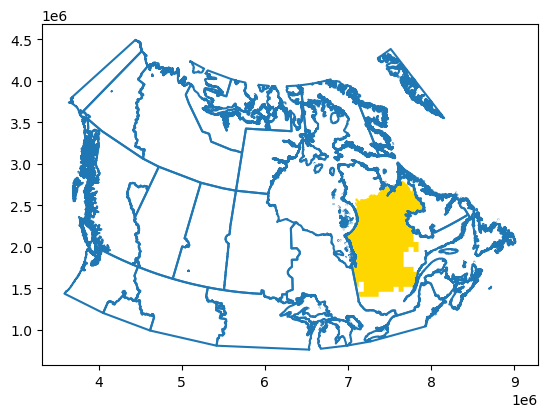

In [52]:
sf_ejb.plot(color = "gold")
tz.to_crs(cproj).boundary.plot(ax = plt.gca())

<AxesSubplot: >

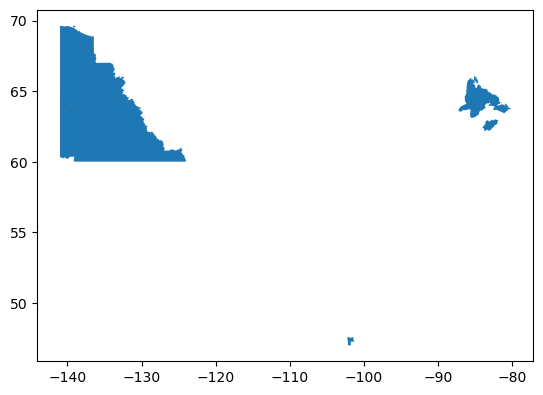

In [141]:
# why does Whitehorse have no timezone?!
tz_no_tz = tz.loc[[z is None for z in tz.UTC_OFFSET]]
tz_no_tz.plot()  # Whitehorse

In [177]:
tz.loc[tz.TZID == "America/Whitehorse", "UTC_OFFSET"] = "UTC-07:00"

In [179]:
tzg = pd.concat([tz.loc[tz.UTC_OFFSET == utc].dissolve() for utc in list(set(tz.UTC_OFFSET))])

geometry            TZID  \
0  MULTIPOLYGON (((-138.64847 69.29833, -138.6283...  America/Denver   

  UTC_OFFSET  
0  UTC-07:00

## **Make shapefile of study region**

In [ ]:
# load source shapefiles (homogeneous fire regions + provinces)
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
provinces = gpd.read_file("sf_provinces").to_crs(cproj)

# clip to border of Quebec
sf_ejb = sf.loc[["WJB", "EJB", "ES"]].clip(provinces.loc[provinces.PRENAME == "Quebec"])

# merge selected HFRs into a single polygon
sf_ejb = sf_ejb.dissolve().explode(index_parts = True)

# get single largest polygon (not necessary in this case but retaining code for ease of future reference)
sf_ejb = sf_ejb.loc[[a == sf_ejb.geometry.area.max() for a in sf_ejb.geometry.area]]

# get external boundary (remove internal features)
sf_ejb["geometry"] = sf_ejb.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))

sf_ejb.to_file("sf_ejb")

<AxesSubplot: >

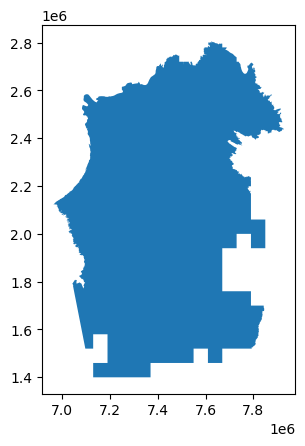

In [4]:
sf_ejb.plot()

## **Regionmasks for ERA5**

In [50]:
era5 = xr.open_dataset("data/fwi_era5_19400101_20230630.nc").fwi.isel(time = 0).reset_coords(drop = True)

In [10]:
# whole of Canada
canada = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(era5.longitude, era5.latitude).sel(region = 3).reset_coords(drop = True)
canada = canada.where(canada == 1)
canada.to_netcdf("data/regionmask_era5_canada.nc")

In [56]:
# study region
sf_ejb = gpd.read_file("sf_ejb").to_crs(cartopy.crs.PlateCarree())
ejb = regionmask.mask_3D_geopandas(sf_ejb, era5.longitude, era5.latitude, numbers = "grid60km_n")
ejb = ejb.where(ejb == 1).squeeze(drop = True)
ejb.to_netcdf("data/regionmask_era5_ejb.nc")

## **GMST time series**

Downloaded from Climate Explorer on July 31st 2023

In [43]:
gmst = decode_times(xr.open_dataset("data/igiss_al_gl_a_4yrlo(1).nc", decode_times = False)).Ta.rename("gmst")
gmst = gmst.assign_coords(time = gmst.time.dt.year).rename(time = "year").sel(year = slice(None, 2025)).dropna("year", "any")
gmst = gmst - gmst.sel(year = 2023)
gmst.to_dataframe().to_csv("data/gmst.csv")

---
---
# **Active fires (MODIS)**

Downloaded from https://firms.modaps.eosdis.nasa.gov/active_fire/  


## **Add regions to active fire data**

In [ ]:
# load all fire data
df = pd.concat([pd.read_csv("data/fire_archive_M-C61_371185.csv"), pd.read_csv("data/fire_nrt_M-C61_371185.csv")])

# convert to geodataframe (standard lat-lon coords) & reproject geometry
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326")
df = df.to_crs(cproj)

# filter out low-confidence points
df = df.loc[df.confidence >= 80]

# add year & month as columns for easier filtering
df["y"] = [int(d[:4]) for d in df.acq_date]
df["m"] = [int(d[5:7]) for d in df.acq_date]

# load shapefile of homogeneous fire regions
sf = gpd.read_file("sf_hfr").to_crs(cproj)

# assign each point to a fire region - takes ages so only doing this once! 
zz = gpd.overlay(df, sf, how='intersection')

# save as .csv (can restore geometry later) - also filter out partial year in 2000
zz.loc[zz.y > 2000].iloc[:,:-1].to_csv("data/modis-active-fires-with-hfr.csv", index = False)

## **Maps of occurrences**

In [44]:
# load all fire data (don't assign fire regions first, as it will remove some points)
df = pd.concat([pd.read_csv("data/fire_archive_M-C61_371185.csv"), pd.read_csv("data/fire_nrt_M-C61_371185.csv")])

# convert to geodataframe (standard lat-lon coords) & reproject geometry
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326")
df = df.to_crs(cproj)

# filter out low-confidence points
df = df.loc[df.confidence >= 60]

# add year & month as columns for easier filtering
df["y"] = [int(d[:4]) for d in df.acq_date]
df["m"] = [int(d[5:7]) for d in df.acq_date]

In [45]:
# shapefile of fire regions
sf_hfr = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)
provinces = gpd.read_file("sf_provinces/").to_crs(cproj).set_index("PRENAME")

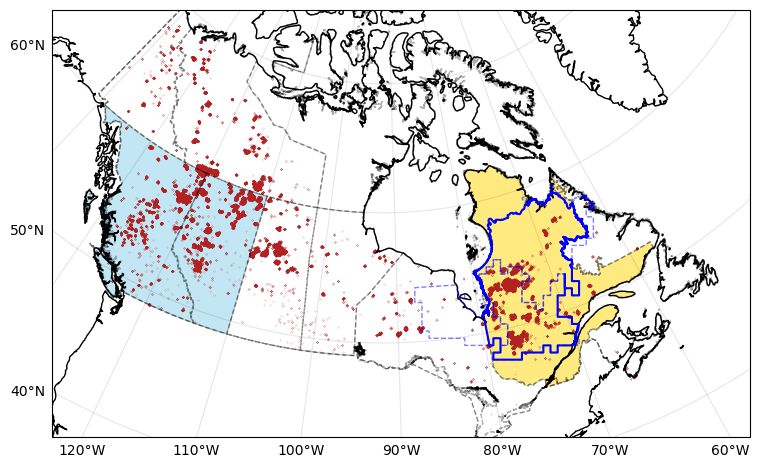

In [46]:
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (9,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.12)

provinces.loc[["Quebec"]].plot(ax = axs, color = "gold", alpha = 0.5)
provinces.loc[["Alberta", "British Columbia"]].plot(ax = axs, color = "skyblue", alpha = 0.5)

# sf.loc[regions].plot(ax = axs[1], color = "gold", alpha = 0.5)

for ax in fig.axes:
    df.loc[(df.y == 2023) & (df.confidence >= 80)].plot(ax = ax, marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    
provinces.boundary.plot(ax = axs, color = "k", lw = 1, ls = "--", alpha = 0.3)

sf_hfr.loc[["EJB", "WJB", "ES"]].boundary.plot(ax = axs, color = "blue", lw = 1, ls = "--", alpha = 0.5)

sf_ejb.boundary.plot(ax = axs, color = "blue", lw = 1.5)

plt.savefig("fig/eventmap_modis-active-fires-2023.png")

In [ ]:
# comparison to previous most severe year in this region
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (14,5), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.12)

for ax in fig.axes: sf.loc[regions].plot(ax = ax, color = "gold", alpha = 0.5)

df.loc[(df.y == 2013) & (df.confidence >= 80)].plot(ax = axs[0], marker = ".", color = "firebrick", alpha = 0.5, markersize = 0.1); axs[0].set_title("2013")
df.loc[(df.y == 2023) & (df.confidence >= 80)].plot(ax = axs[1], marker = ".", color = "firebrick", alpha = 0.5, markersize = 0.1); axs[1].set_title("2023")

for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.7)
    
# plt.savefig("fig/eventmap_modis-active-fires-2023-2013.png")

## **Cumulative burned area**

In [106]:
df = pd.read_csv("data/modis-active-fires-with-hfr.csv", low_memory = False, parse_dates = ["acq_date"])
df = df.loc[(df.confidence >= 80)]

In [119]:
# identify unique pixels and label by date first identified
unique_px = df.groupby(["latitude", "longitude"])[["acq_date", "y"]].first()

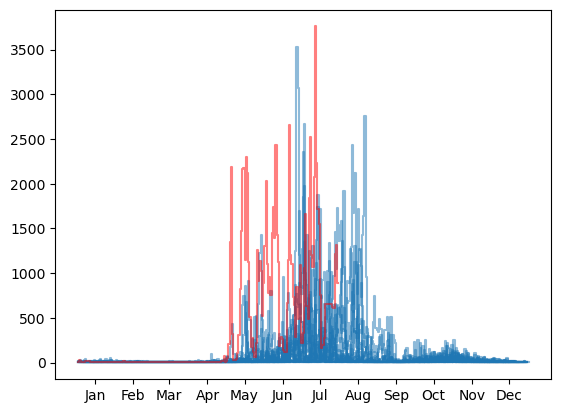

In [167]:
for y in range(2001,2023):
    px_y = unique_px.loc[unique_px.y == y].groupby("acq_date").count()
    plt.plot(px_y.index.dayofyear, px_y, color = "tab:blue", alpha = 0.5, drawstyle = "steps")
    
y=2023
px_y = unique_px.loc[unique_px.y == y].groupby("acq_date").count()
plt.plot(px_y.index.dayofyear, px_y, color = "red", alpha = 0.5, drawstyle = "steps")
# not actually what I intended, but quite like this, keeping for ref

ax = plt.gca()
days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 1]

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
print("")

In [168]:
px_daily = unique_px.groupby(["y", "acq_date"])[["y"]].count()

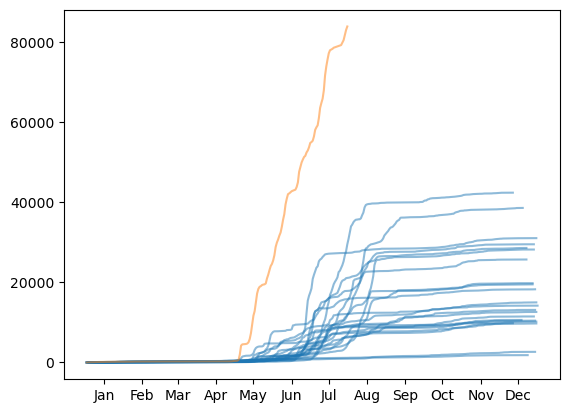

In [170]:
for y in range(2001,2023):
    plt.plot(px_daily.loc[y, "y"].index.dayofyear, px_daily.loc[y, "y"].cumsum(), color = "tab:blue", alpha = 0.5)
plt.plot(px_daily.loc[2023, "y"].index.dayofyear, px_daily.loc[2023, "y"].cumsum(), color = "tab:orange", alpha = 0.5)

ax = plt.gca()
days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 1]

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
print("")
# not really sure if this is unique pixels so won't include - just kept here for reference

## **Fires per HFR**

In [20]:
df = pd.read_csv("data/modis-active-fires-with-hfr.csv", low_memory = False)

In [5]:
# aggregate annually by fire region
nfires_cy = df[["y","NAMES_SHOR"]].groupby(["y", "NAMES_SHOR"])["NAMES_SHOR"].count().unstack()
nfires_mjj = df.loc[[m in [5,6,7] for m in df.m], ["y","NAMES_SHOR"]].groupby(["y", "NAMES_SHOR"])["NAMES_SHOR"].count().unstack()

regions = ["EJB", "ES", "WJB"]

Text(0.5, 0.98, 'Active fires per HFR during different seasons as multiple of 2000-2022 mean (eastern hot spot)')

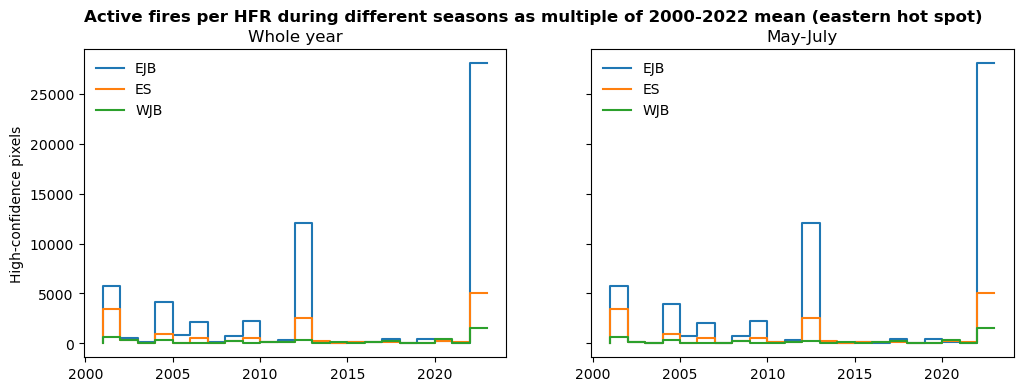

In [12]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True, sharex = True)

nfires_cy[regions].plot(ax = axs[0], drawstyle = "steps", ylabel = "High-confidence pixels", xlabel = "")
axs[0].set_title("Whole year")

nfires_mjj[regions].plot(ax = axs[1], drawstyle = "steps", xlabel = "")
axs[1].set_title("May-July")

for ax in axs: ax.legend(edgecolor = "w", loc = "upper left")

plt.suptitle("Active fires per HFR during different seasons as multiple of 2000-2022 mean (eastern hot spot)", fontweight = "bold")
# not only is the May-June rate unusual but there are already 10-20 times more fires in May-June 2023 than we would expect in the whole year/fire season
# Definitely suggest focussing on this eastern region

# plt.savefig("fig/event-def_active-fires-per-year.png")

Text(0.5, 0.98, 'Active fires per HFR during different seasons as multiple of 2000-2022 mean (eastern hot spot)')

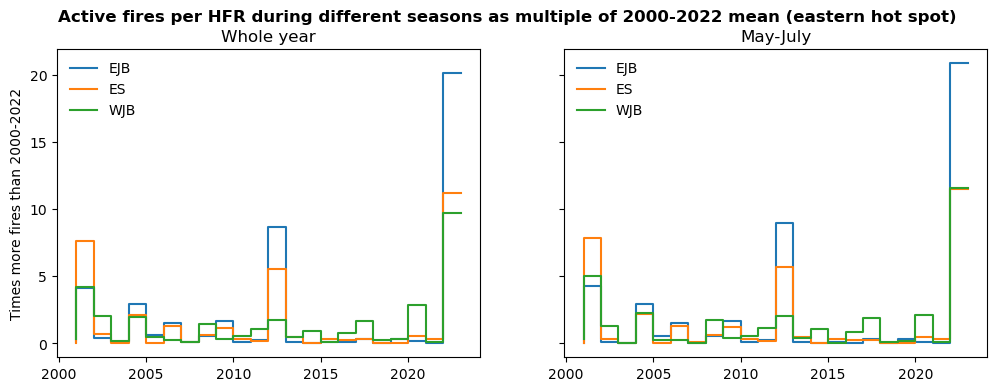

In [13]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True, sharex = True)

(nfires_cy / nfires_cy.loc[slice(None, "2022")].mean(axis = 0))[regions].plot(ax = axs[0], drawstyle = "steps", ylabel = "Times more fires than 2000-2022", xlabel = "")
axs[0].set_title("Whole year")

(nfires_mjj / nfires_mjj.loc[slice(None, "2022")].mean(axis = 0))[regions].plot(ax = axs[1], drawstyle = "steps", xlabel = "")
axs[1].set_title("May-July")

for ax in axs: ax.legend(edgecolor = "w", loc = "upper left")

plt.suptitle("Active fires per HFR during different seasons as multiple of 2000-2022 mean (eastern hot spot)", fontweight = "bold")
# not only is the May-June rate unusual but there are already 10-20 times more fires in May-June 2023 than we would expect in the whole year/fire season
# Definitely suggest focussing on this eastern region

# plt.savefig("fig/event-def_active-fires-per-year-as-multiple.png")

In [15]:
(nfires_cy / nfires_cy.loc[slice(None, "2022")].mean(axis = 0))[regions].loc[2023]

NAMES_SHOR
EJB    20.177987
ES     11.185096
WJB     9.676997
Name: 2023, dtype: float64

In [14]:
(nfires_mjj / nfires_mjj.loc[slice(None, "2022")].mean(axis = 0))[regions].loc[2023]

NAMES_SHOR
EJB    20.871452
ES     11.519703
WJB    11.607776
Name: 2023, dtype: float64

---
---
# **Indices**

## **fwi7x**

### **Time series for climate explorer**


In [8]:
# compute fwi7x
fwi7x = xr.open_dataset("data/fwi_era5_19400101_20230630.nc").fwi.rolling(time = 7).mean().resample(time = "AS-JAN").max().sel(time = slice("1941", None))

# add Lambert coordinates for plotting
x,y = latlon_to_lambert(fwi7x.isel(time = 0))
fwi7x = fwi7x.assign_coords(x = (["latitude", "longitude"], x), y = (["latitude", "longitude"], y))

# mask off study region
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask
fwi7x = fwi7x.where(rm_ejb == 1)
fwi7x.to_netcdf("data/era5_fwi7x.nc")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# average over study region
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask
fwi7x_ts = fwi7x.mean(["latitude", "longitude"])

# specify filename
csv_fnm = "ts/canada-wildfires_era5_fwi7x.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 fwi7x - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# fwi7x [] spatial mean of maximum of 7-day average of FWI over wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year fwi7x"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
fwi7x_ts.assign_coords(time = fwi7x_ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Event map + timeseries**

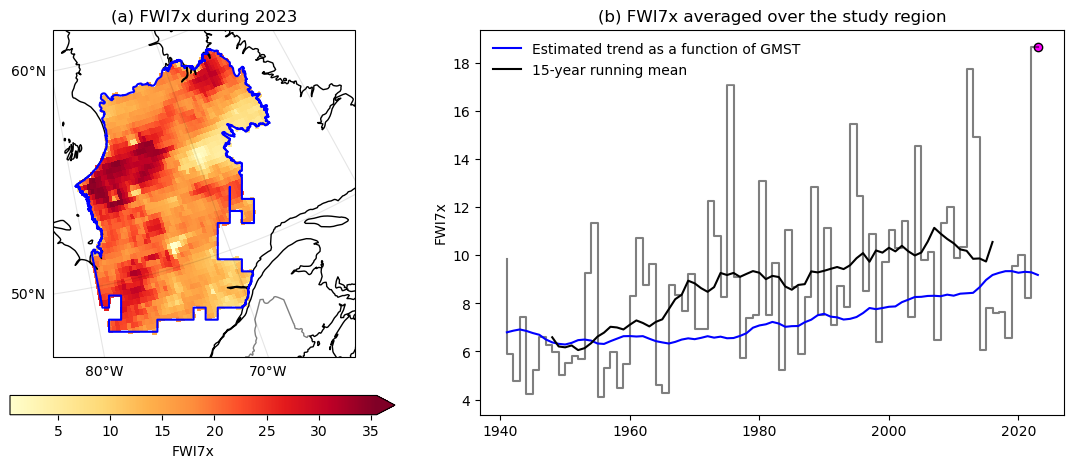

In [42]:
fwi7x_2023 = xr.open_dataset("data/era5_fwi7x.nc").sel(time = "2023-01-01").fwi
fwi7x_ts = pd.read_csv("ts/canada-wildfires_era5_fwi7x.dat", comment = "#", sep = " ", header = None, names = ["year", "fwi7x"], index_col = 0)

# load shapefile for plotting
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

fitted_loc = pd.read_csv("data/era5_fitted-location_fwi7x.csv", index_col = 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig = plt.figure(figsize=(14,5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1.3]) 
plt.subplots_adjust(wspace = 0.1)
plot_kwargs = {"cmap" : "YlOrRd"}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

map_ax =  plt.subplot(gs[0], projection = cproj)
cbar = map_ax.pcolormesh(fwi7x_2023.x,fwi7x_2023.y,fwi7x_2023, **plot_kwargs)
map_ax.pcolormesh(fwi7x_2023.x,fwi7x_2023.y,fwi7x_2023.where(fwi7x_2023 == 0), cmap = "Blues")

# labels, shapefile boundaries etc
map_ax.coastlines()
map_ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
map_ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
sf_ejb.boundary.plot(ax = map_ax, color = "blue", lw = 1.5)
    
plt.colorbar(cbar, ax = map_ax, location = "bottom", fraction = 0.05, pad = 0.1, label = "FWI7x", extend = "max")
map_ax.set_title("(a) FWI7x during 2023")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(gs[1])

ts_ax.plot(fwi7x_ts, drawstyle = "steps", color = "k", alpha = 0.5)
ts_ax.plot(fitted_loc, color = "blue", label = "Estimated trend as a function of GMST")
ts_ax.plot(fwi7x_ts.rolling(15, center = True).mean(), color = "k", label = "15-year running mean")
ts_ax.set_ylabel("FWI7x")
ts_ax.legend(edgecolor = "w")
ts_ax.scatter(2023, fwi7x_ts.loc[2023], color = "magenta", edgecolor = "k")
ts_ax.set_title("(b) FWI7x averaged over the study region")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.savefig("fig/eventmap_era5_fwi7x.png")

### **fwi7x & active fires**

In [ ]:
# load data, convert to geodataframe & reproject to correct geometry
df = pd.read_csv("data/modis-active-fires-with-hfr.csv", low_memory = False)
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326")
df = df.to_crs(cproj)

# shapefile of fire regions
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
regions = ["EJB", "ES", "WJB"]

Text(0.5, 0.98, 'Monthly maximum of 7-day rolling FWI in each grid cell')

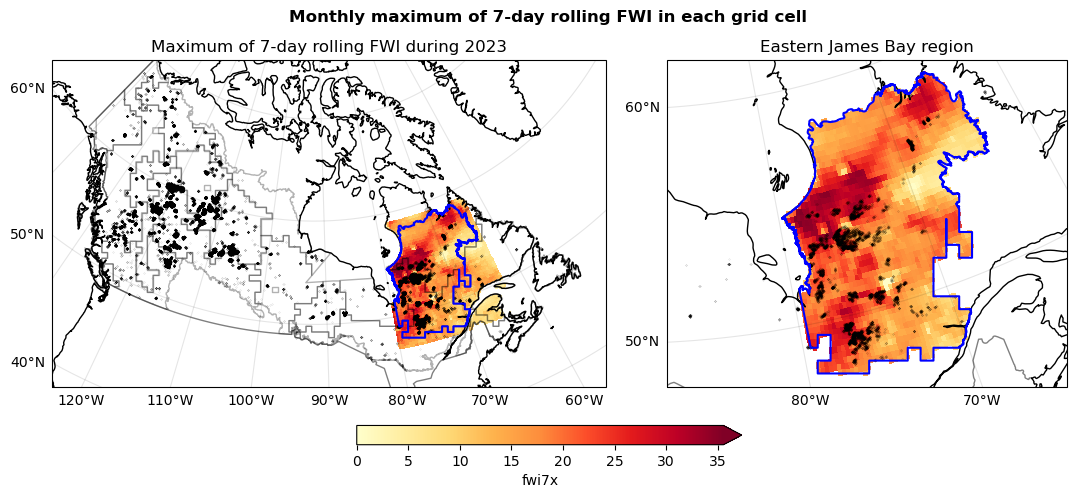

In [ ]:
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0}

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (13.5,5), dpi = 100, subplot_kw = {"projection" : cproj}, gridspec_kw = {"width_ratios" : [1.3,1]})
plt.subplots_adjust(wspace = 0.06)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cbar = axs[0].pcolormesh(fwi7x_2023.x,fwi7x_2023.y,fwi7x_2023, **plot_kwargs)
axs[0].pcolormesh(fwi7x_2023.x,fwi7x_2023.y,fwi7x_2023.where(fwi7x_2023 == 0), cmap = "Blues")
axs[0].set_title("Maximum of 7-day rolling FWI during 2023")
sf.boundary.plot(ax = axs[0], color = "k", lw = 1, alpha = 0.3)

df.loc[(df.y == 2023) & (df.confidence >= 80)].plot(ax = axs[0], marker = ".", color = "k", alpha = 0.3, markersize = 0.1)

axs[1].pcolormesh(fwi7x_ejb.x,fwi7x_ejb.y,fwi7x_ejb, **plot_kwargs)
axs[1].pcolormesh(fwi7x_ejb.x,fwi7x_ejb.y,fwi7x_ejb.where(fwi7x_ejb == 0), cmap = "Blues")

axs[1].set_title("Eastern James Bay region")

df.loc[(df.y == 2023) & (df.confidence >= 80) & ([r in ["EJB", "WJB", "ES"] for r in df.NAMES_SHOR])].plot(ax = axs[1], marker = ".", color = "k", alpha = 0.3, markersize = 0.1)


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    sf_ejb.boundary.plot(ax = ax, color = "blue", lw = 1.5)

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "fwi7x", extend = "max")

plt.suptitle("Monthly maximum of 7-day rolling FWI in each grid cell", fontweight = "bold")

### **Other maps**

#### **Event map + daily FWI**

In [ ]:
fwi7x = xr.open_dataset("data/era5_fwi7x-monthly.nc").fwi7x

rm_canada = xr.open_dataset("data/regionmask_era5_canada.nc").mask
fwi7x_2023 = fwi7x.sel(time = "2023").max("time").where(rm_canada == 1)

x,y = [np.loadtxt("data/lambert-"+d+"_era5.csv") for d in ["x", "y"]]    # load Lambert projected coordinates
fwi7x_2023 = fwi7x_2023.assign_coords(x = (["latitude", "longitude"], x), y = (["latitude", "longitude"], y))

rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")
fwi7x_ejb = fwi7x_2023.where(rm_ejb == 1)

# load shapefiles for plotting
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

fwi7 = xr.open_dataset("data/fwi_era5_19400101_20230630.nc").fwi.load().sel(time = slice("1941", None)).rolling(time = 7, center = False).mean()
fwi_ejb = xr.open_dataset("")

fwi_ejb = xr.open_dataset("data/era5_fwi_study-region.nc").fwi.rolling(time = 7, center = False).mean()

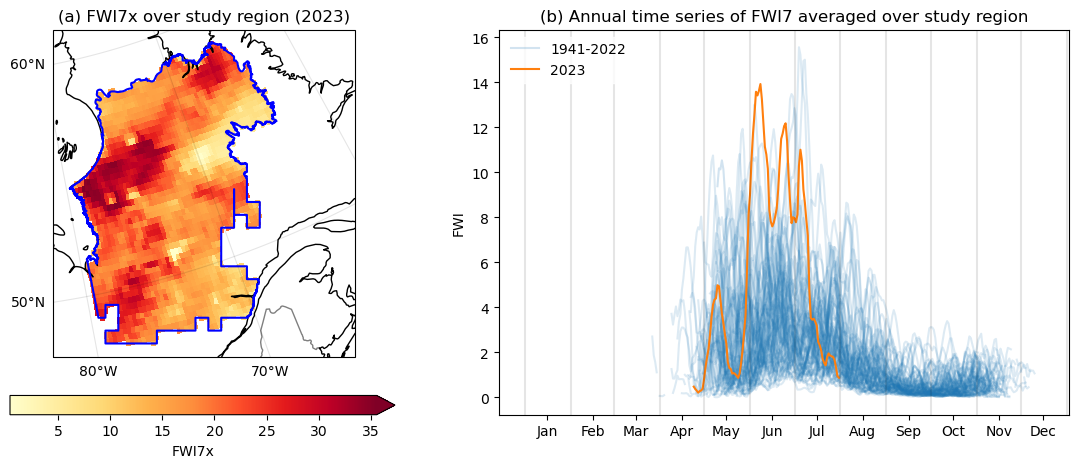

In [26]:
from matplotlib import gridspec

fig = plt.figure(figsize=(14,5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1.3]) 
plt.subplots_adjust(wspace = 0.15)
plot_kwargs = {"cmap" : "YlOrRd"}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

map_ax =  plt.subplot(gs[0], projection = cproj)
cbar = map_ax.pcolormesh(fwi7x_ejb.x,fwi7x_ejb.y,fwi7x_ejb, **plot_kwargs)
map_ax.pcolormesh(fwi7x_ejb.x,fwi7x_ejb.y,fwi7x_ejb.where(fwi7x_ejb == 0), cmap = "Blues")

# labels, shapefile boundaries etc
map_ax.coastlines()
map_ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
map_ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
sf_ejb.boundary.plot(ax = map_ax, color = "blue", lw = 1.5)
    
plt.colorbar(cbar, ax = map_ax, location = "bottom", fraction = 0.05, pad = 0.1, label = "FWI7x", extend = "max")
map_ax.set_title("(a) FWI7x over study region (2023)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(gs[1])
    
for y in range(1941,2022):
    fwi_y = fwi_ejb.sel(time = str(y))
    ts_ax.plot(fwi_y.time.dt.dayofyear, fwi_y, color = "tab:blue", alpha = 0.15)

y = 2022
fwi_y = fwi_ejb.sel(time = str(y))
ts_ax.plot(fwi_y.time.dt.dayofyear, fwi_y, color = "tab:blue", alpha = 0.2, label = "1941-2022")
    
y = 2023
fwi_y = fwi_ejb.sel(time = str(y))
ts_ax.plot(fwi_y.time.dt.dayofyear, fwi_y, color = "tab:orange", alpha = 1, label = "2023")

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 1]
ts_ax.set_xticks(labelticks)
ts_ax.set_xticklabels(labels)

ts_ax.set_title("(b) Annual time series of FWI7 averaged over study region")
ts_ax.set_ylabel("FWI")

ts_ax.legend(loc = "upper left", edgecolor = "w")

[ts_ax.axvline(i, color = "k", alpha = 0.1) for i in range(366) if (days[i].day) == 1]
ts_ax.axvline(366, color = "k", alpha = 0.1)

plt.savefig("fig/eventmap_era5_fwi7x.png")

#### **Timing of annual maxima**

Text(0, 0.5, 'Month')

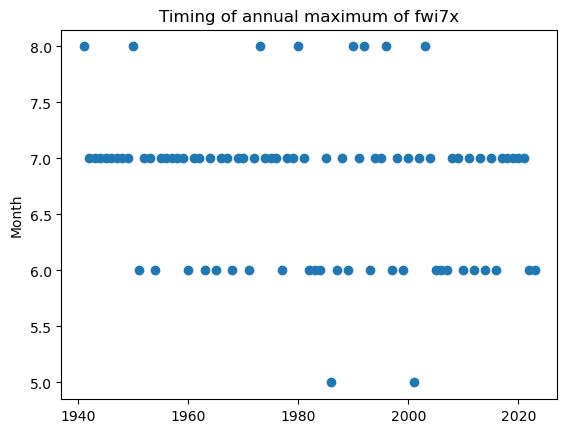

In [25]:
fwi7x_m = fwi7x.where(rm_ejb).mean(["latitude", "longitude"])
m_max = xr.concat([fwi7x_m.sel(time = str(y)).idxmax().dt.month.expand_dims(year = [y]) for y in range(1941,2024)], "year")
plt.scatter(m_max.year, m_max)
plt.title("Timing of annual maximum of fwi7x")
plt.ylabel("Month")

#### **Annual fwi7x**

In [33]:
fwi7x_ymax = fwi7x.resample(time = "AS-JAN").max()

x,y = [np.loadtxt("data/lambert-"+d+"_era5.csv") for d in ["x", "y"]]    # load Lambert projected coordinates
fwi7x_ymax = fwi7x_ymax.assign_coords(x = (["latitude", "longitude"], x), y = (["latitude", "longitude"], y))

Text(0.5, 0.98, 'Annual maximum of 7-day rolling FWI in each grid cell')

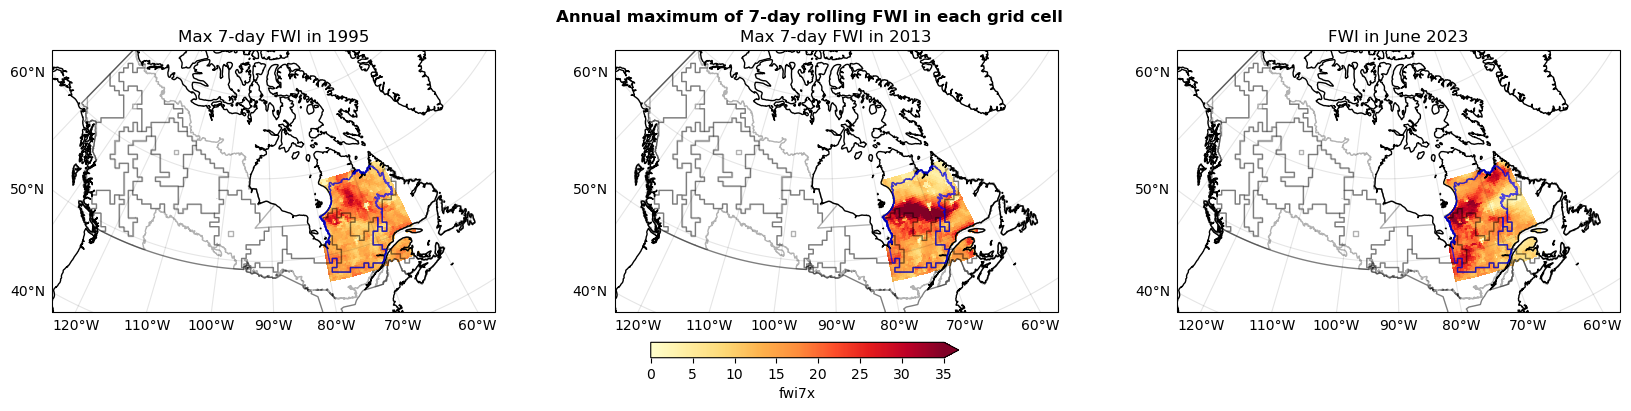

In [35]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (21,4), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.12)
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0, "vmax" : 35}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cbar = axs[0].pcolormesh(fwi7x_ymax.x,fwi7x_ymax.y,fwi7x_ymax.where(rm_canada ==1).sel(time = "1995-01-01"), **plot_kwargs)
axs[0].set_title("Max 7-day FWI in 1995")

cbar = axs[1].pcolormesh(fwi7x_ymax.x,fwi7x_ymax.y,fwi7x_ymax.where(rm_canada ==1).sel(time = "2013-01-01"), **plot_kwargs)
axs[1].set_title("Max 7-day FWI in 2013")

axs[2].pcolormesh(fwi7x_ymax.x,fwi7x_ymax.y,fwi7x_ymax.where(rm_canada ==1).sel(time = "2023-01-01"), **plot_kwargs)
axs[2].set_title("FWI in June 2023")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.3)
    sf_ejb.boundary.plot(ax = ax, color = "blue", lw = 1, alpha = 0.7)

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "fwi7x", extend = "max")

plt.suptitle("Annual maximum of 7-day rolling FWI in each grid cell", fontweight = "bold")

#### **Correlation with number of active fires**


In [41]:
# load active fire data
df = pd.read_csv("data/modis-active-fires-with-hfr.csv", low_memory = False)
df = df.loc[df.acq_date < "2023-07"] # only include up to end of June

# aggregate annually by fire region
nfires = df[["y","NAMES_SHOR"]].groupby(["y", "NAMES_SHOR"])["NAMES_SHOR"].count().unstack()[["EJB", "ES"]].sum(axis = 1)

In [ ]:
# where available, approximate linear relationship with log of number of fires (Pearson correlation coeff 0.79) - especially for very high/very low values
plt.scatter(fwi7x_ts.sel(time = slice("2001",None)), np.log(nfires))
xyline(fwi7x_ts.sel(time = slice("2001",None)), np.log(nfires), ax = plt.gca())
np.corrcoef(fwi7x_ts.sel(time = slice("2001",None)), np.log(nfires))[0,1]

#### **FWINx - sensitivity to ndays**

In [43]:
# Monthly maximum of N-day rolling mean of FWI (processed per decade to avoid handling 7gb of data at once)
fwiNx = []
for y in range(1940,2030,10):
    
    # load daily FWI, replace all missing values with 0 (needed for correct averaging over region)
    fwi = xr.open_dataset("data/fwi_era5_19400101_20230630.nc").fwi.load()
    fwi = fwi.where(~np.isnan(fwi), 0)
    
    # monthly maximum of 7-day rolling mean of FWI
    fwiN = xr.concat([fwi.rolling(time = ndays).mean().resample(time = "AS-JAN").max().expand_dims(ndays = [ndays]) for ndays in [5,7,9,11,13,15]], "ndays")
    
    # add to list
    fwiNx.append(fwiN)

# concatenate the decades into a single dataArray & rename
fwiNx = xr.concat(fwiNx, "time").rename("fwiNx")

# ensure that all values are nonnegative (sometimes occurs due to numerical instabilities)
fwiNx = fwiNx.where(fwiNx >= 0, 0)

# apply Canada regionmask
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")
fwiNx = fwiNx.where(rm_ejb == 1).mean(["latitude", "longitude"])

fwiNx.assign_coords(time = fwiNx.time.dt.year).rename(time = "year").to_pandas().transpose().to_csv("data/era5_fwiNx_annual.csv")

In [45]:
fwiNx = pd.read_csv("data/era5_fwiNx_annual.csv", index_col = "time")
import matplotlib.cm as cm

(fwiNx - fwiNx.mean(axis = 0)).plot(drawstyle = "steps")
[xyline(fwiNx.index, (fwiNx - fwiNx.mean(axis = 0))[ndays], ax = plt.gca(), color = cm.tab10(fwiNx.columns.tolist().index(ndays))) for ndays in fwiNx.columns.tolist()]
plt.legend(fwiNx.columns.tolist(), ncols = 2)

# slightly stronger trend for shorter time series - very little difference between 9 & 15 days

ValueError: Index time invalid

---
## **Cumulative DSR**

### **Time series for climate explorer**


In [3]:
# annual cumulative DSR in each grid cell (cutting in January if no 'off season' occurs)
fwi = xr.open_dataset("data/fwi_era5_19400101_20230630.nc").fwi
dsr = (fwi ** 1.71) * 0.0272

# add Lambert coordinates for plotting
x,y = latlon_to_lambert(dsr.isel(time = 0))
dsr = dsr.assign_coords(x = (["latitude", "longitude"], x), y = (["latitude", "longitude"], y)).rename("dsr")

# mask off study region
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask
dsr = dsr.where(rm_ejb == 1)
dsr.to_netcdf("data/era5_dsr.nc")

cumdsr = dsr.sel(time = [m <= 7 for m in dsr.time.dt.month]).resample(time = "AS-JAN").sum().rename("cumdsr").where(rm_ejb == 1)
cumdsr.to_netcdf("data/era5_cumdsr.nc")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cumdsr_ts = cumdsr.mean(["latitude", "longitude"])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# specify filename
csv_fnm = "ts/canada-wildfires_era5_cumdsr.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 cumdsr - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# cumdsr [] spatial mean of cumulative DSR each January to July over wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year cumdsr"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

cumdsr_ts.assign_coords(time = cumdsr_ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Event map  + daily accumulation of DSR**

In [11]:
cumdsr_2023 = xr.open_dataset("data/era5_cumdsr.nc").cumdsr.sel(time = "2023-01-01")
dsr_ts = xr.open_dataset("data/era5_dsr.nc").dsr.mean(["latitude", "longitude"])

# load shapefile for plotting
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

In [18]:
xr.ones_like(cumdsr_2023).where(cumdsr_2023 >= 21.3, 0).where(~np.isnan(cumdsr_2023)).mean()

<xarray.DataArray 'cumdsr' ()>
array(0.9237947, dtype=float32)
Coordinates:
    time     datetime64[ns] 2023-01-01

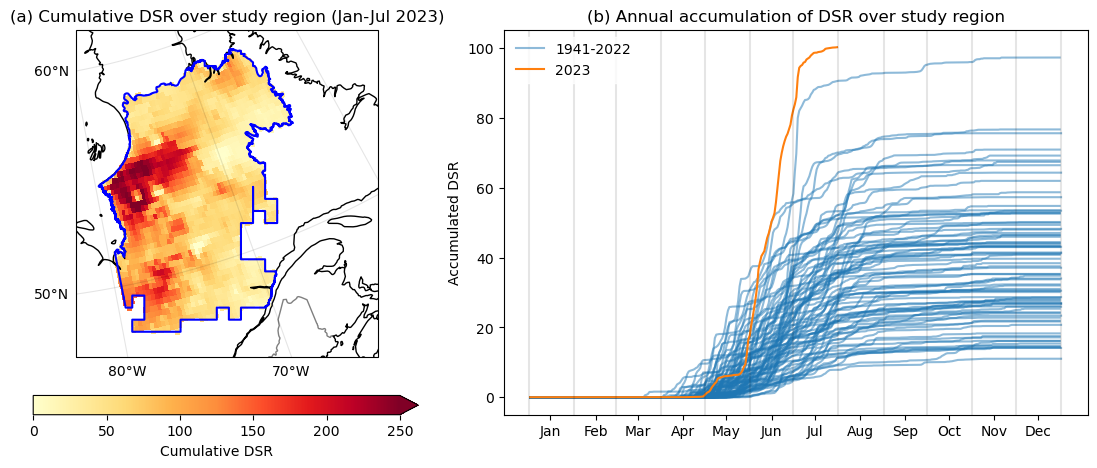

In [13]:
fig = plt.figure(figsize=(14,5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1.3]) 
plt.subplots_adjust(wspace = 0.1)
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0, "vmax" : 250}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

map_ax =  plt.subplot(gs[0], projection = cproj)
cbar = map_ax.pcolormesh(cumdsr_2023.x,cumdsr_2023.y,cumdsr_2023, **plot_kwargs)
map_ax.pcolormesh(cumdsr_2023.x,cumdsr_2023.y,cumdsr_2023.where(cumdsr_2023 == 0), cmap = "Blues")

# labels, shapefile boundaries etc
map_ax.coastlines()
map_ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
map_ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
sf_ejb.boundary.plot(ax = map_ax, color = "blue", lw = 1.5)
    
plt.colorbar(cbar, ax = map_ax, location = "bottom", fraction = 0.05, pad = 0.1, label = "Cumulative DSR", extend = "max")
map_ax.set_title("(a) Cumulative DSR over study region (Jan-Jul 2023)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(gs[1])
    
for y in range(1941,2022):
    dsr_y = dsr_ts.sel(time = str(y))
    ts_ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.5)

y = 2022
dsr_y = dsr_ts.sel(time = str(y))
ts_ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.5, label = "1941-2022")
    
y = 2023
dsr_y = dsr_ts.sel(time = str(y))
ts_ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:orange", alpha = 1, label = "2023")

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 1]
ts_ax.set_xticks(labelticks)
ts_ax.set_xticklabels(labels)

ts_ax.set_title("(b) Annual accumulation of DSR over study region")
ts_ax.set_ylabel("Accumulated DSR")

ts_ax.legend(loc = "upper left", edgecolor = "w")

[ts_ax.axvline(i, color = "k", alpha = 0.1) for i in range(366) if (days[i].day) == 1]
ts_ax.axvline(366, color = "k", alpha = 0.1)

plt.savefig("fig/eventmap_era5_cumdsr-2023.png")

### **Relationship between FWI and DSR**

In [17]:
fwi = xr.open_dataset("data/fwi_era5_19400101_20230630.nc").fwi
fwi = fwi.where(~np.isnan(fwi), 0)
dsr = (fwi ** 1.71) * 0.0272

Text(0, 0.5, 'DSR')

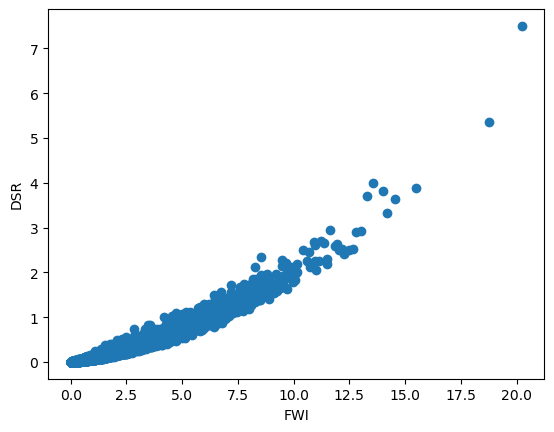

In [20]:
plt.scatter(fwi.mean(["latitude", "longitude"]), dsr.mean(["latitude", "longitude"]))
plt.xlabel("FWI"); plt.ylabel("DSR")

---
# **Spatial patterns**

## **Temperature**

In [121]:
varnm = "tas"
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

highresmip_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_*highresSST*"))
cmip6_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_day*hist*"))
cordex_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_NAM-22_*"))

era5 = decode_times(xr.open_dataset("data/spatial/era5_t2m_daily_-145--50E_40-80N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_1.nc", decode_times = False)).t2m
era5 = era5.groupby("time.month").mean("time")
era5 = convert_units_to(era5.sel(month = [6,7,8]).mean("month"), "degC")

def overlay_details(ax):
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))

#================================================================================================================================================

fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (26,10), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.18, hspace = 0.02)
plot_kwargs = {"cmap" : "RdBu_r", "vmin" : -20, "vmax" : 20}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ERA5
x,y = latlon_to_lambert(era5.rename(lon = "longitude", lat = "latitude"))
axs[0,0].pcolormesh(x,y,era5, **plot_kwargs)
axs[0,0].set_title("ERA5")
overlay_details(axs[0,0])

axs[0,1].set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# highresmip
for i in range(len(highresmip_fl)):
    ax = axs[0,i+2]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    da = convert_units_to(da.sel(month = [6,7,8]).mean("month"), "degC")
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" "+fnm.split("_")[4])
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CMIP6
for i in range(len(cmip6_fl)):
    ax = axs[1,i]
    fnm = cmip6_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    da = convert_units_to(da.sel(month = [6,7,8]).mean("month"), "degC")
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2])
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# regional models
for i in range(len(cordex_fl)):
    ax = axs[2,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" REMO2015")
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,3].set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,4].set_title("CanESM2-CanRCM4")
lens = xr.open_dataset("data/spatial/sp-tas_NAM-44_CCCma-CanESM2_CCCma-CanRCM4_r2.nc").tas.mean("time")
x,y = latlon_to_lambert(lens.rename(lon = "longitude", lat = "latitude"))
axs[2,4].pcolormesh(x,y,lens, **plot_kwargs)
axs[2,4].set_title("CanESM2-CanRCM4")
overlay_details(axs[2,4])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,5].set_title("CRCM5")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.suptitle("Spatial pattern of JJA temperature in ERA5 & models", fontweight = "bold", y = 0.9)
plt.savefig("fig/spatial-pattern-tas.png")

## **Precipitation**

In [4]:
varnm = "pr"
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

highresmip_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_*highresSST*"))
cmip6_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_day*hist*"))
cordex_fl = sorted(glob.glob("data/spatial/sp-"+varnm+"_NAM-22_*"))

era5 = decode_times(xr.open_dataset("data/spatial/era5_tp_daily_-145--50E_40-80N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_1.nc", decode_times = False)).tp
era5 = era5.groupby("time.month").mean("time")
era5 = era5.sel(month = [3,4,5,6,7]).mean("month")

def overlay_details(ax):
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))

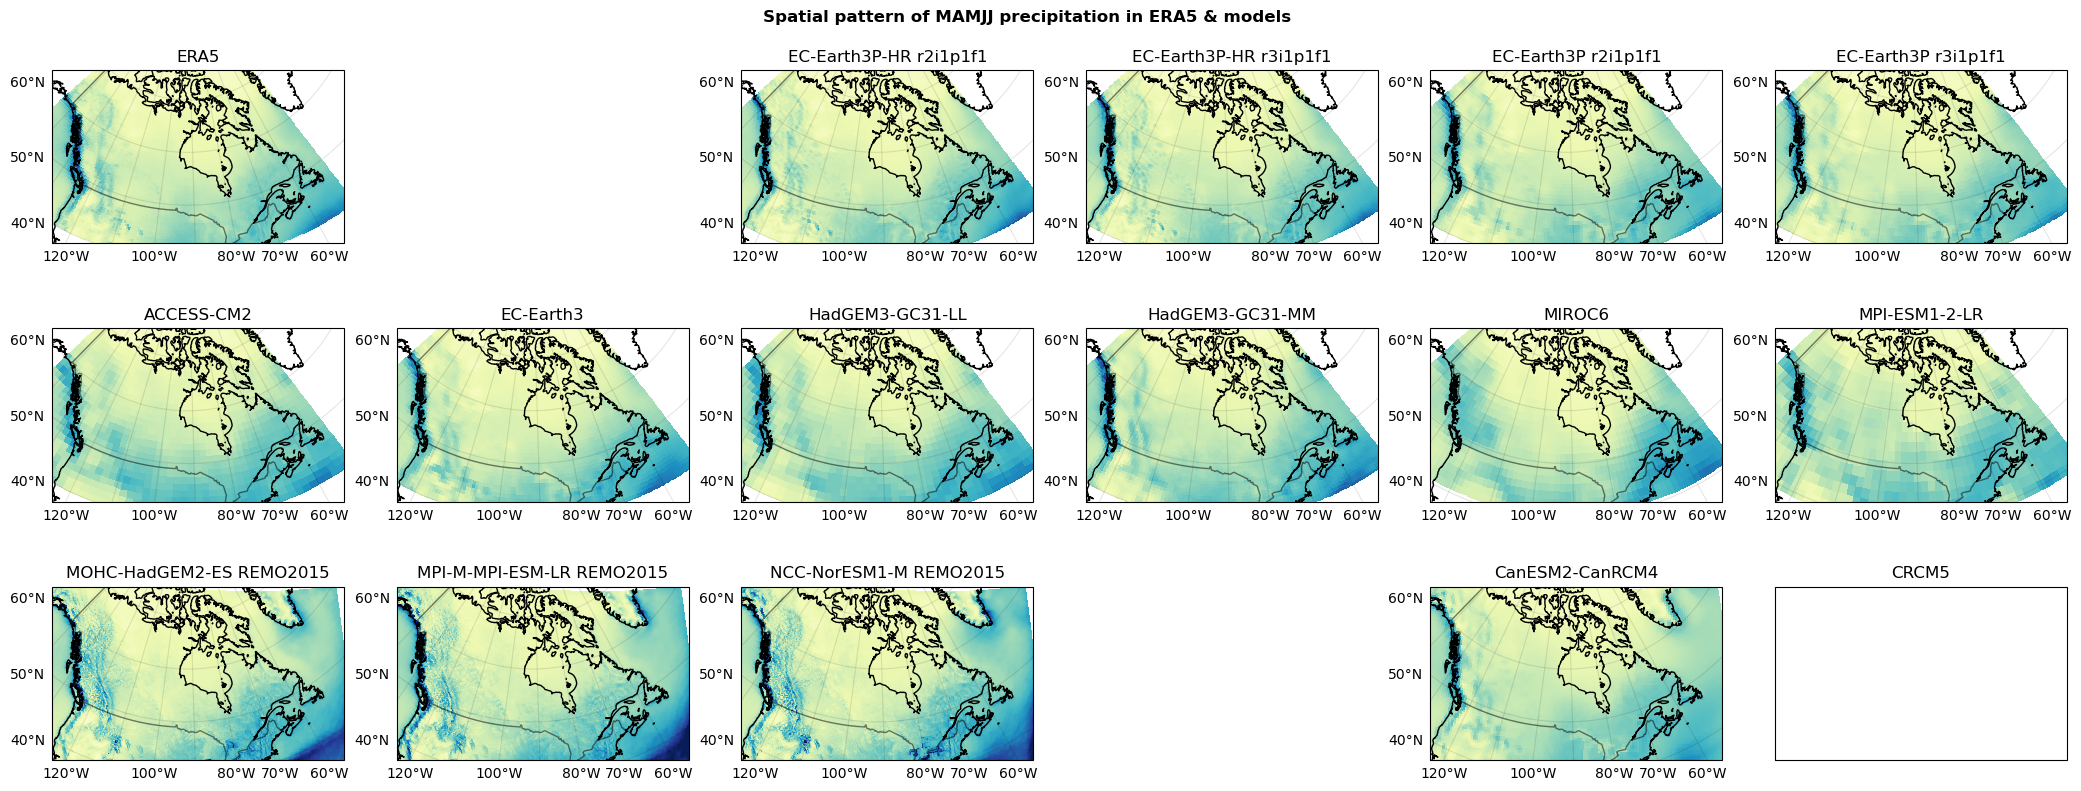

In [9]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (26,10), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.18, hspace = 0.02)
plot_kwargs = { "cmap" : "YlGnBu", "vmin" : 0 , "vmax" : 8}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ERA5
x,y = latlon_to_lambert(era5.rename(lon = "longitude", lat = "latitude"))
axs[0,0].pcolormesh(x,y,era5, **plot_kwargs)
axs[0,0].set_title("ERA5")
overlay_details(axs[0,0])

axs[0,1].set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# highresmip
for i in range(len(highresmip_fl)):
    ax = axs[0,i+2]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    da = convert_units_to(da.sel(month = [3,4,5,6,7]).mean("month"), "mm/day")
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" "+fnm.split("_")[4])
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CMIP6
for i in range(len(cmip6_fl)):
    ax = axs[1,i]
    fnm = cmip6_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    da = convert_units_to(da.sel(month = [3,4,5,6,7]).mean("month"), "mm/day")
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2])
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# regional models
for i in range(len(cordex_fl)):
    ax = axs[2,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm)[varnm]
    x,y = latlon_to_lambert(da.rename(lon = "longitude", lat = "latitude"))
    ax.pcolormesh(x,y,da, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" REMO2015")
    overlay_details(ax)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,3].set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
lens = xr.open_dataset("data/spatial/sp-pr_NAM-44_CCCma-CanESM2_CCCma-CanRCM4_r2.nc").pr
x,y = latlon_to_lambert(lens.rename(lon = "longitude", lat = "latitude"))
axs[2,4].pcolormesh(x,y,lens, **plot_kwargs)
overlay_details(axs[2,4])
axs[2,4].set_title("CanESM2-CanRCM4")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[2,5].set_title("CRCM5")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.suptitle("Spatial pattern of MAMJJ precipitation in ERA5 & models", fontweight = "bold", y = 0.9)
plt.savefig("fig/spatial-pattern-pr.png")

---
---
# **Initial noodlings**

---
## **Monthly severity rating**

In [190]:
# Monthly mean of daily severity rating
msr = []
for y in range(1940,2030,10):
    
    fwi = xr.open_mfdataset("data/era5/fwi_era5_"+str(y)+"-"+str(y+9)+".nc").fwi.load()
    fwi = fwi.where(~np.isnan(fwi), 0)
    dsr = (fwi ** 1.71) * 0.0272
    msr.append(dsr.resample(time = "MS").mean().rename("msr"))
    
msr = xr.concat(msr, "time")

# apply Canada regionmask
rm_canada = xr.open_dataset("data/regionmask_era5_canada.nc").mask
msr = msr.where(rm_canada == 1)

msr.to_netcdf("data/era5_msr-monthly.nc")

### **Monthly MSR**

In [44]:
msr = xr.open_dataset("data/era5_msr-monthly.nc").msr

x,y = [np.loadtxt("data/lambert-"+d+"_era5.csv") for d in ["x", "y"]]    # load Lambert projected coordinates
msr = msr.assign_coords(x = (["latitude", "longitude"], x), y = (["latitude", "longitude"], y))

# load shapefiles for plotting
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

# load regionmasks
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")

msr_ejb = msr.where(rm_ejb == 1)

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


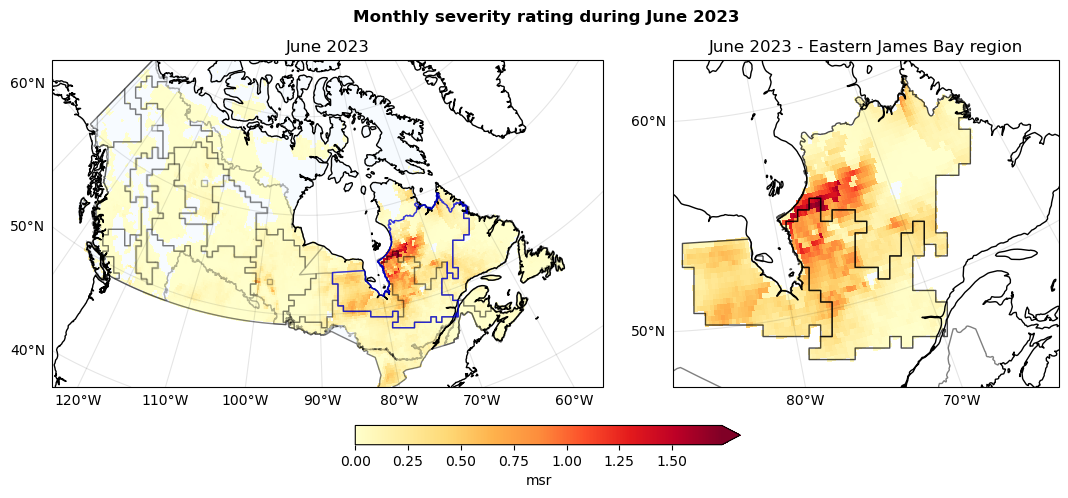

In [242]:
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0}

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (13.5,5), dpi = 100, subplot_kw = {"projection" : cproj}, gridspec_kw = {"width_ratios" : [1.3,1]})
plt.subplots_adjust(wspace = 0.06)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cbar = axs[0].pcolormesh(x,y,msr.sel(time = "2023-06-01"), **plot_kwargs)
axs[0].pcolormesh(x,y,msr.where(msr == 0).sel(time = "2023-06-01"), cmap = "Blues")
axs[0].set_title("June 2023")
sf.boundary.plot(ax = axs[0], color = "k", lw = 1, alpha = 0.3)
sf_ejb.boundary.plot(ax = axs[0], color = "blue", lw = 1, alpha = 0.7)

axs[1].pcolormesh(msr_ejb.x,msr_ejb.y,msr_ejb.sel(time = "2023-06-01"), **plot_kwargs)
axs[1].pcolormesh(msr_ejb.x,msr_ejb.y,msr_ejb.where(msr_ejb == 0).sel(time = "2023-06-01"), cmap = "Blues")

sf.loc[regions].boundary.plot(ax = axs[1], color = "k", lw = 1, alpha = 0.7)
axs[1].set_title("June 2023 - Eastern James Bay region")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "msr", extend = "max")

plt.suptitle("Monthly severity rating during June 2023", fontweight = "bold")

plt.savefig("fig/event-def_msr-2023.png")
# maps aren't going to add much beyond the fwi7x ones - include as supplement only

### **Time series of max vs mean**

In [49]:
msr_mj_mean = msr.sel(time = [m in [5,6] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").mean().expand_dims(mtype = ["mj_mean"])
msr_mjja_mean = msr.sel(time = [m in [5,6,7,8] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").mean().expand_dims(mtype = ["mjja_mean"])

msr_mj_max = msr.sel(time = [m in [5,6] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").max().expand_dims(mtype = ["mj_max"])
msr_mjja_max = msr.sel(time = [m in [5,6,7,8] for m in msr.time.dt.month]).where(rm_ejb == 1).mean(["latitude", "longitude"]).resample(time = "AS-JAN").max().expand_dims(mtype = ["mjja_max"])

In [97]:
xr.concat([msr_mj_mean, msr_mjja_mean, msr_mj_max, msr_mjja_max], "mtype").assign_coords(time = msr_mj_mean.time.dt.year).rename(time = "year").to_pandas().transpose().to_csv("data/era5_severity-ratings.csv")

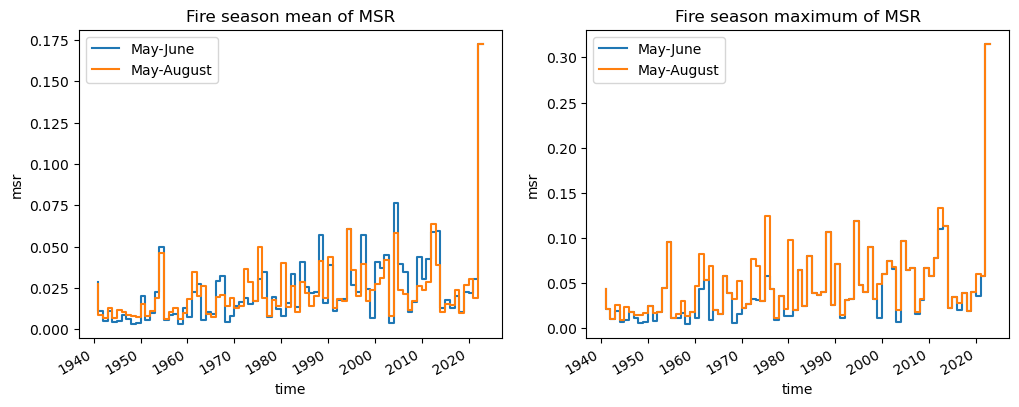

In [297]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

msr_mj_mean.plot(ax = axs[0], drawstyle = "steps", label = "May-June")
msr_mjja_mean.plot(ax = axs[0], drawstyle = "steps", label = "May-August")
axs[0].set_title("Fire season mean of MSR")
axs[0].legend()

msr_mj_max.plot(ax = axs[1], drawstyle = "steps", label = "May-June")
msr_mjja_max.plot(ax = axs[1], drawstyle = "steps", label = "May-August")
axs[1].set_title("Fire season maximum of MSR")
axs[1].legend()

### **Time series for climate explorer**


In [19]:
# load monthly severity rating data
msr = xr.open_dataset("data/era5_msr-monthly.nc").msr

rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")
msr_ejb = msr.where(rm_ejb == 1).mean(["latitude", "longitude"])

msr_ejb_ts = msr_ejb.sel(time = [m in [5,6] for m in msr_ejb.time.dt.month]).resample(time = "AS-JAN").mean()

In [21]:
# fix filename
csv_fnm = "ts/canada-wildfires_era5_msr-mj.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 MSR-MJ - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# msr [] mean daily severity rating during May and June over wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year msr"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
msr_ejb_ts.assign_coords(time = msr_ejb_ts.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Event map**

In [22]:
msr = xr.open_dataset("data/era5_msr-monthly.nc").msr.sel(time = slice("2023-05", "2023-06")).mean("time")

x,y = [np.loadtxt("data/lambert-"+d+"_era5.csv") for d in ["x", "y"]]    # load Lambert projected coordinates
msr = msr.assign_coords(x = (["latitude", "longitude"], x), y = (["latitude", "longitude"], y))

# load shapefiles for plotting
sf = gpd.read_file("sf_hfr").to_crs(cproj).set_index("NAMES_SHOR")
sf_ejb = gpd.read_file("sf_ejb").to_crs(cproj)

# load regionmasks
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")
msr_ejb = msr.where(rm_ejb == 1)

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


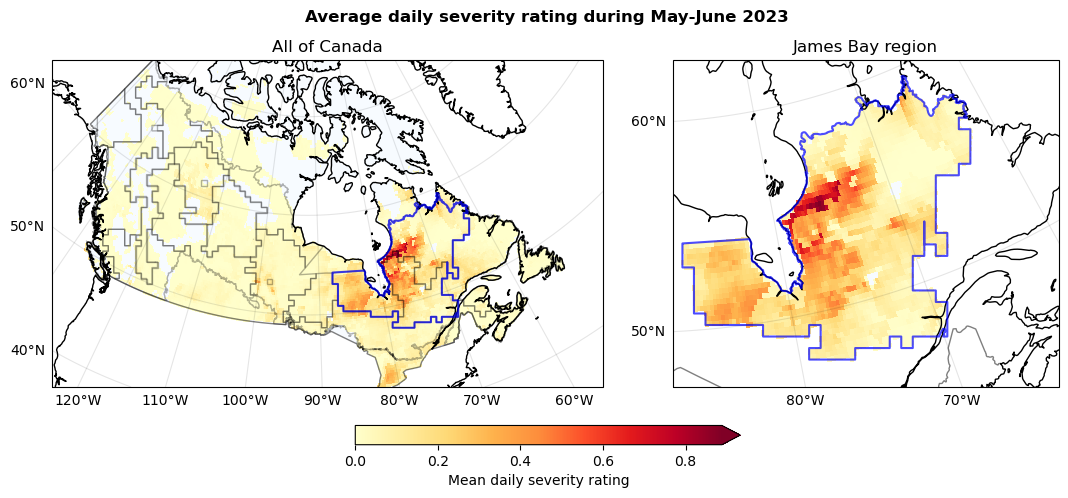

In [27]:
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0}

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (13.5,5), dpi = 100, subplot_kw = {"projection" : cproj}, gridspec_kw = {"width_ratios" : [1.3,1]})
plt.subplots_adjust(wspace = 0.06)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cbar = axs[0].pcolormesh(x,y,msr, **plot_kwargs)
axs[0].pcolormesh(x,y,msr.where(msr == 0), cmap = "Blues")
axs[0].set_title("All of Canada")
sf.boundary.plot(ax = axs[0], color = "k", lw = 1, alpha = 0.3)

axs[1].pcolormesh(msr_ejb.x,msr_ejb.y,msr_ejb, **plot_kwargs)
axs[1].pcolormesh(msr_ejb.x,msr_ejb.y,msr_ejb.where(msr_ejb == 0), cmap = "Blues")

# sf.loc[regions].boundary.plot(ax = axs[1], color = "k", lw = 1, alpha = 0.7)
axs[1].set_title("James Bay region")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    sf_ejb.boundary.plot(ax = ax, color = "blue", lw = 1.5, alpha = 0.7)

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "Mean daily severity rating", extend = "max")

plt.suptitle("Average daily severity rating during May-June 2023", fontweight = "bold")

plt.savefig("fig/event-def_msr-2023.png")
# maps aren't going to add much beyond the fwi7x ones - include as supplement only

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


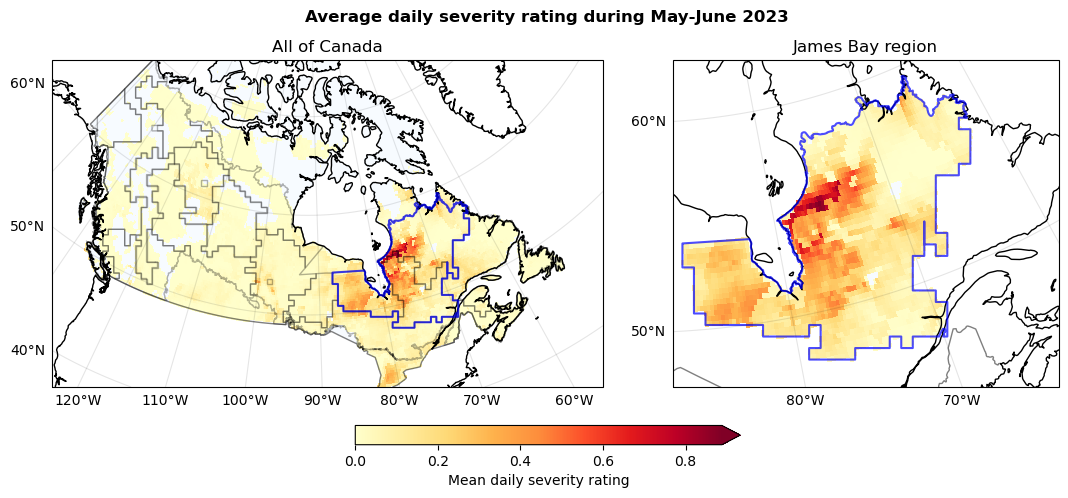

In [27]:
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0}

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (13.5,5), dpi = 100, subplot_kw = {"projection" : cproj}, gridspec_kw = {"width_ratios" : [1.3,1]})
plt.subplots_adjust(wspace = 0.06)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cbar = axs[0].pcolormesh(x,y,msr, **plot_kwargs)
axs[0].pcolormesh(x,y,msr.where(msr == 0), cmap = "Blues")
axs[0].set_title("All of Canada")
sf.boundary.plot(ax = axs[0], color = "k", lw = 1, alpha = 0.3)

axs[1].pcolormesh(msr_ejb.x,msr_ejb.y,msr_ejb, **plot_kwargs)
axs[1].pcolormesh(msr_ejb.x,msr_ejb.y,msr_ejb.where(msr_ejb == 0), cmap = "Blues")

# sf.loc[regions].boundary.plot(ax = axs[1], color = "k", lw = 1, alpha = 0.7)
axs[1].set_title("James Bay region")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    sf_ejb.boundary.plot(ax = ax, color = "blue", lw = 1.5, alpha = 0.7)

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = "Mean daily severity rating", extend = "max")

plt.suptitle("Average daily severity rating during May-June 2023", fontweight = "bold")

plt.savefig("fig/event-def_msr-2023.png")
# maps aren't going to add much beyond the fwi7x ones - include as supplement only

## **fwi99**

### **Time series for climate explorer**


In [7]:
# 99th percentile of FWI in across all cells in study region (processed per decade to avoid handling 7gb of data at once)
fwi_99_mj = []
fwi_99_mjja = []

# load regionmask to select area of interest
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")

# loop over decadal files & compute indices
for y in range(1940,2030,10):
    
    # load daily FWI, replace all missing values with 0 (needed for correct averaging over region)
    fwi = xr.open_mfdataset("data/era5/fwi_era5_"+str(y)+"-"+str(y+9)+".nc").fwi.load()
    fwi = fwi.where(~np.isnan(fwi), 0).where(rm_ejb == 1)
    
    # find 99th percentile of FWI per year & add to list
    fwi_99_mj.append(fwi.sel(time = [m in [5,6] for m in fwi.time.dt.month]).resample(time = "AS-JAN").quantile(0.99, ["latitude", "longitude", "time"]))
    fwi_99_mjja.append(fwi.sel(time = [m in [5,6,7,8] for m in fwi.time.dt.month]).resample(time = "AS-JAN").quantile(0.99, ["latitude", "longitude", "time"]))
    
# concatenate the decades into a single dataArray & rename
fwi_99_mj = xr.concat(fwi_99_mj, "time").reset_coords(drop = True)
fwi_99_mjja = xr.concat(fwi_99_mjja, "time").reset_coords(drop = True)

In [12]:
fwi_99 = xr.concat([fwi_99_mj.expand_dims(months = ["mj"]), fwi_99_mjja.expand_dims(months = ["mjja"])], "months").assign_coords(time = fwi_99_mj.time.dt.year).rename(time = "year")

In [16]:
fwi_99.to_pandas().transpose().to_csv("data/era5_fwi99.csv")

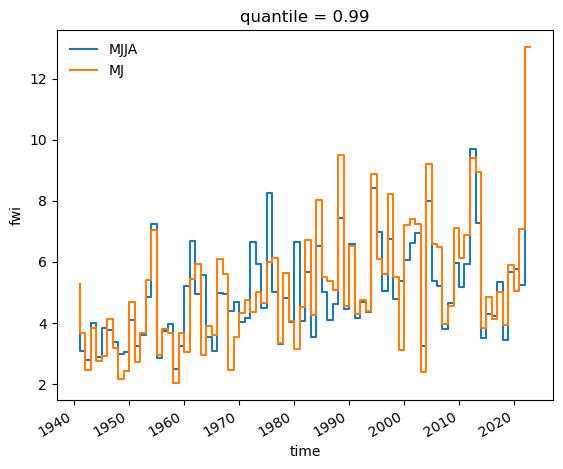

In [243]:
fwi_99_mjja.plot(drawstyle = "steps", label = "MJJA")
fwi_99_mj.plot(drawstyle = "steps", label = "MJ")
plt.legend(edgecolor = "w")

plt.savefig("fig/event-def_fwi99-ts.png")

In [272]:
# fix filename
csv_fnm = "ts/canada-wildfires_era5_fwi99-mj.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 fwi99_mj - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# fwi99_mj [] 99th percentile of May-June FWI over all days & grid cells in wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year fwi99_mj"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
fwi_99_mj.assign_coords(time = fwi_99_mj.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [273]:
# fix filename
csv_fnm = "ts/canada-wildfires_era5_fwi99-mjja.dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 fwi99_mjja - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# fwi99_mjja [] 99th percentile of May-August FWI over all days & grid cells in wider Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year fwi99_mjja"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
fwi_99_mjja.assign_coords(time = fwi_99_mjja.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Distribution of FWI annually**


In [111]:
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")

In [138]:
fwi_2005 = xr.open_dataset("data/era5/fwi_era5_2000-2009.nc").fwi.load().sel(time = slice("2005-05", "2005-08")).where(rm_ejb == 1)
fwi_2013 = xr.open_dataset("data/era5/fwi_era5_2010-2019.nc").fwi.load().sel(time = slice("2013-05", "2013-08")).where(rm_ejb == 1)
fwi_2023 = xr.open_dataset("data/era5/fwi_era5_2020-2029.nc").fwi.load().sel(time = slice("2023-05", "2023-08")).where(rm_ejb == 1)

In [141]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100)

for i in range(3):
    y = ["2005", "2013", "2023"][i]
    ax = axs[i]
    
    fwi_da = eval("fwi_"+y)
    
    ax.hist((fwi_da.sel(time = slice(y+"-05", y+"-06")).stack(txy = ["time", "latitude", "longitude"])), bins = "fd", density = True, alpha = 0.5, label = "May-June "+y)
    ax.hist((fwi_da.stack(txy = ["time", "latitude", "longitude"])), bins = "fd", density = True, alpha = 0.5, label = "May-August "+y)
    ax.legend(edgecolor = "w")
    
    ax.axvline(fwi_da.sel(time = slice(y+"-05", y+"-06")).quantile(0.99), alpha = 0.5)
    ax.axvline(fwi_da.sel(time = slice(y+"-05", y+"-08")).quantile(0.99), alpha = 0.5, color = "tab:orange")
   
    ax.set_ylim(0,.1)
    ax.set_xlim(0,20)
    ax.set_title("Distribution of daily FWI in EJB ("+y+")")

### **FWI99 map**

In [23]:
fwi_2005 = xr.open_dataset("data/era5/fwi_era5_2000-2009.nc").fwi.load().sel(time = slice("2005-05", "2005-08"))
fwi_2013 = xr.open_dataset("data/era5/fwi_era5_2010-2019.nc").fwi.load().sel(time = slice("2013-05", "2013-08"))
fwi_2017 = xr.open_dataset("data/era5/fwi_era5_2010-2019.nc").fwi.load().sel(time = slice("2017-05", "2017-08"))
fwi_2023 = xr.open_dataset("data/era5/fwi_era5_2020-2029.nc").fwi.load().sel(time = slice("2023-05", "2023-08"))

In [8]:
sf = gpd.read_file("sf_hfr").to_crs(cartopy.crs.PlateCarree()).set_index("NAMES_SHOR")
rm_hfr = regionmask.mask_3D_geopandas(sf, fwi_2023.longitude, fwi_2023.latitude, numbers = "grid60km_n")

In [16]:
for y in [2005,2013,2017,2023]:
    sf["q99_"+str(y)] = eval("fwi_"+str(y)).where(rm_hfr).quantile(0.99, ["latitude", "longitude", "time"])

In [15]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,4), dpi = 100)

for i in range(3):
    y = ["2005", "2013", "2017","2023"][i]
    ax = axs[i]
    
    sf.plot(ax = ax, column = "q99_"+y)
    
    ax.hist((fwi_da.sel(time = slice(y+"-05", y+"-06")).stack(txy = ["time", "latitude", "longitude"])), bins = "fd", density = True, alpha = 0.5, label = "May-June "+y)
    ax.hist((fwi_da.stack(txy = ["time", "latitude", "longitude"])), bins = "fd", density = True, alpha = 0.5, label = "May-August "+y)
    ax.legend(edgecolor = "w")
    
    ax.axvline(fwi_da.sel(time = slice(y+"-05", y+"-06")).quantile(0.99), alpha = 0.5)
    ax.axvline(fwi_da.sel(time = slice(y+"-05", y+"-08")).quantile(0.99), alpha = 0.5, color = "tab:orange")
   
    ax.set_ylim(0,.1)
    ax.set_xlim(0,20)
    ax.set_title("Distribution of daily FWI in EJB ("+y+")")

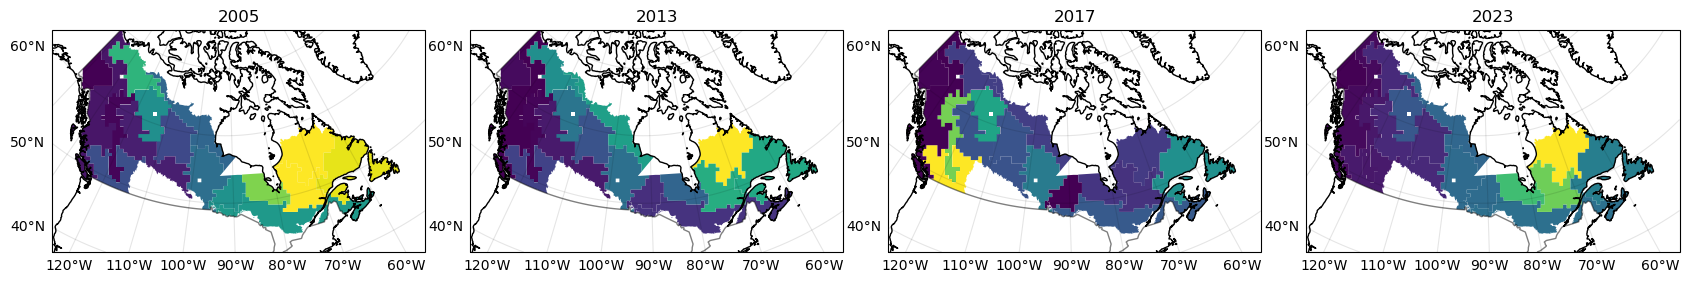

In [26]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (21,4), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.12)
plot_kwargs = {"cmap" : "YlOrRd", "vmin" : 0, "vmax" : 17.5}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(4):
    y = ["2005", "2013", "2017","2023"][i]
    ax = axs[i]
    
    cbar = sf.to_crs(cproj).plot(ax = ax, column = "q99_"+y)
    ax.set_title(y)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# labels, shapefile boundaries etc
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.3)
    # sf_ejb.boundary.plot(ax = ax, color = "blue", lw = 1, alpha = 0.7)

---
## **Days exceeding quantiles**

In [2]:
# # compute the quantiles
# fwi = xr.open_mfdataset("data/era5/fwi_era5_*.nc").fwi
# fwi = fwi.where(~np.isnan(fwi), 0)

# rm_canada = xr.open_dataset("data/regionmask_era5_canada.nc").mask
# fwi = fwi.where(rm_canada == 1)

# fwi_mj = fwi.sel(time = [m in [5,6] for m in fwi.time.dt.month]).load()
# fwi_mjja = fwi.sel(time = [m in [5,6,7,8] for m in fwi.time.dt.month]).load()

# fwi_mj_qq = fwi_mj.sel(time = slice("1941", "2022")).quantile([0.95,0.99], "time").expand_dims(months = ["mj"])
# fwi_mjja_qq = fwi_mj.sel(time = slice("1941", "2022")).quantile([0.95,0.99], "time").expand_dims(months = ["mjja"])

# fwi_qq = xr.concat([fwi_mj_qq, fwi_mjja_qq], "months")
# fwi_qq.to_netcdf("data/era5_fwi-quantile-maps.nc")

In [98]:
fwi_qq = xr.open_dataset("data/era5_fwi-quantile-maps.nc").fwi
rm_canada = xr.open_dataset("data/regionmask_era5_canada.nc").mask

In [ ]:
# Monthly maximum of 7-day rolling mean of FWI (processed per decade to avoid handling 7gb of data at once)
fwiqqx = []
for y in range(1940,2030,10):
    
    # load daily FWI, replace all missing values with 0 (needed for correct averaging over region)
    fwi = xr.open_mfdataset("data/era5/fwi_era5_"+str(y)+"-"+str(y+9)+".nc").fwi.load()
    fwi_x = fwi.where(fwi > fwi_qq)
    
    mj = [m in [5,6] for m in fwi_x.time.dt.month]
    mjja = [m in [5,6,7,8] for m in fwi_x.time.dt.month]

    # count number of exceedances each year
    fwi_x_mj = fwi_x.sel(months = "mj", time = mj).resample(time = "AS-JAN").count().where(rm_canada == 1).expand_dims(months = ["mj"])
    fwi_x_mjja = fwi_x.sel(months = "mjja", time = mjja).resample(time = "AS-JAN").count().where(rm_canada == 1).expand_dims(months = ["mjja"])
    
    fwiqqx.append(xr.concat([fwi_x_mj, fwi_x_mjja], "months"))

In [99]:
fwi_qq.sel(months = "MJJA")

<xarray.DataArray 'fwi' (months: 2, quantile: 2, latitude: 157, longitude: 373)>
[234244 values with dtype=float32]
Coordinates:
  * months     (months) object 'mj' 'mjja'
  * latitude   (latitude) float32 41.0 41.25 41.5 41.75 ... 79.5 79.75 80.0
  * longitude  (longitude) float32 -143.0 -142.8 -142.5 ... -50.5 -50.25 -50.0
  * quantile   (quantile) float64 0.95 0.99

In [ ]:
# concatenate the decades into a single dataArray & rename
fwiqqx = xr.concat(fwiqqx, "time").rename("fwiqqx")

# and save
fwiqqx.to_netcdf("data/era5_fwiqqx-annual.nc")

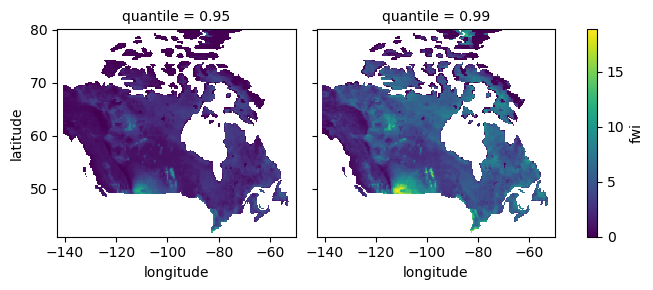

In [146]:
fwi_qq.plot(col = "quantile")

In [129]:
rm_ejb = xr.open_dataset("data/regionmask_era5_ejb.nc").mask.dropna("longitude", "all").dropna("latitude", "all")
fwiqqx = xr.open_dataset("data/era5_fwiqqx-annual.nc").fwiqqx
fwiqqx_ts = fwiqqx.where(rm_ejb == 1).mean(["latitude", "longitude"])

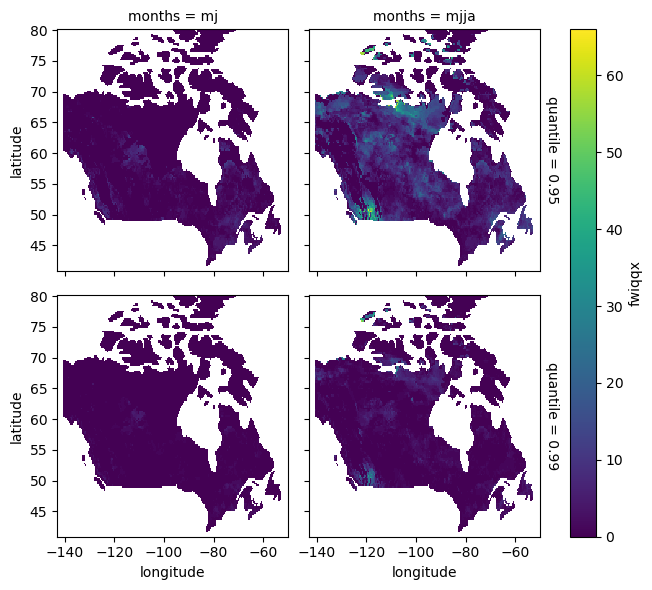

In [144]:
fwiqqx.sel(time = "2017-01-01").plot(row = "quantile", col = "months")

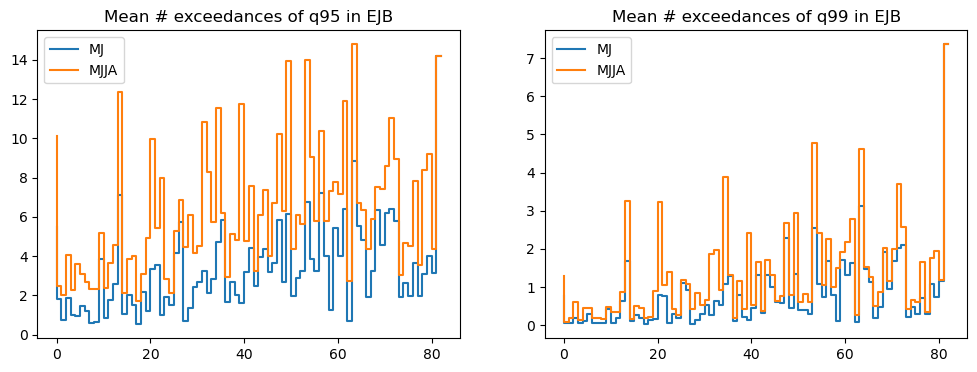

In [140]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

axs[0].plot(fwiqqx_ts.sel(quantile = 0.95).transpose(), drawstyle = "steps")
axs[0].set_title("Mean # exceedances of q95 in EJB")
axs[0].legend(["MJ", "MJJA"])

axs[1].plot(fwiqqx_ts.sel(quantile = 0.99).transpose(), drawstyle = "steps")
axs[1].set_title("Mean # exceedances of q99 in EJB")
axs[1].legend(["MJ", "MJJA"])